In [ ]:

!pip install -q star-privateer lightkurve==2.4.2 george tqdm pathos --break-system-packages

# 2. IMPORTS
import lightkurve as lk
import star_privateer as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.stats import sigma_clip
from scipy.signal import detrend
import astropy.units as u

In [ ]:
# 3. DOWNLOAD ALL AVAILABLE SECTORS
sectors = [6, 12, 67, 68, 69]

print("Clearing cache and downloading sectors:", sectors)
!rm -rf /root/.lightkurve/cache

lcf = lk.search_lightcurve(f"TIC {tic}", author="SPOC", exptime=120, sector=sectors)
print(f"Found {len(lcf)} light curve files")

# Download and stitch
lc_list = lcf.download_all()
if not lc_list:
    raise ValueError("No data found – something wrong with TIC or sectors")

lc = lc_list[0].remove_nans().normalize()
for extra in lc_list[1:]:
    lc = lc.append(extra.remove_nans().normalize())

lc = lc.remove_outliers(sigma=7)
t, f = lc.time.value, lc.flux

print(f"Success! Stitched LC: {len(t):,} points, {t[-1]-t[0]:.1f} days baseline")

Clearing cache and downloading sectors: [6, 12, 67, 68, 69]
Found 5 light curve files
Success! Stitched LC: 76,173 points, 1737.8 days baseline


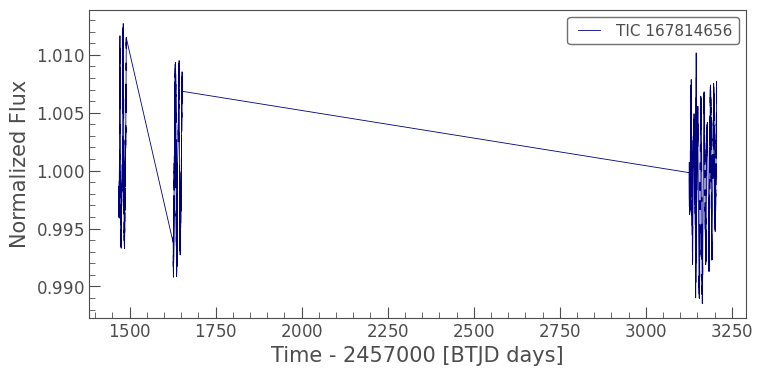

In [ ]:
# Quick plot
lc.plot(lw=0.6, color='navy', title=f"HIP 33690 – Sectors {sectors}")
plt.savefig("HIP33690_full_LC.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 900x400 with 0 Axes>

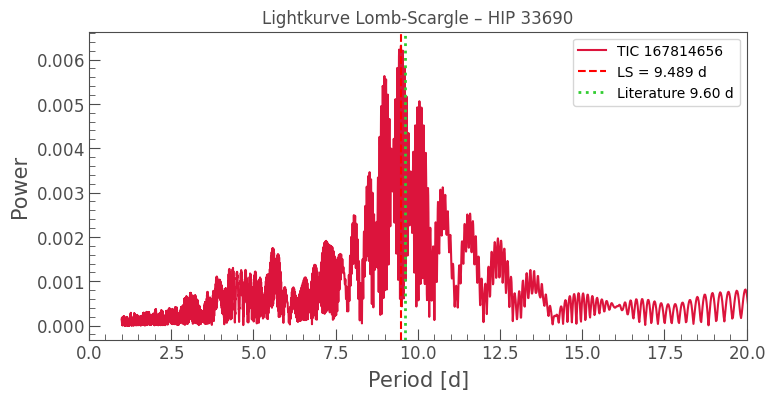

In [ ]:
# 4. Lightkurve Lomb-Scargle
pg = lc.to_periodogram(method='lombscargle', minimum_period=1*u.day, maximum_period=30*u.day, oversample_factor=10)
ls_period = pg.period_at_max_power.value

plt.figure(figsize=(9,4))
pg.plot(color='crimson', lw=1.5)
plt.axvline(ls_period, color='red', ls='--', label=f'LS = {ls_period:.3f} d')
plt.axvline(9.6, color='limegreen', lw=2, ls=':', label='Literature 9.60 d')
plt.xlim(0, 20)
plt.title("Lightkurve Lomb-Scargle – HIP 33690")
plt.legend()
plt.savefig("HIP33690_LS.png", dpi=300)
plt.show()

In [ ]:
periods = []
for i in range(100):
    resampled_lc = lc[np.random.choice(len(lc), len(lc), replace=True)]


    resampled_lc_cleaned = resampled_lc.remove_nans()

    if len(resampled_lc_cleaned.time) < 2:

        continue


    try:
        pg_res = resampled_lc_cleaned.to_periodogram(method='lombscargle', minimum_period=0.1 * u.day, maximum_period=20 * u.day)
        periods.append(pg_res.period_at_max_power.value)
    except Exception as e:

        continue

# Ensure we have at least one valid period to compute std
if len(periods) > 0:
    ls_period_err = np.std(periods)
    print(f"With Bootstrap Error: {ls_period:.4f} ± {ls_period_err:.4f} days")
else:
    print("Could not compute bootstrap error: No valid periodograms were calculated from resamples.")

With Bootstrap Error: 9.4895 ± 1.7904 days


In [ ]:
# 5. Pre-process for Star-Privateer
f_values_raw = f.value

if isinstance(f_values_raw, np.ma.MaskedArray):
    f_values = f_values_raw.filled(np.nan).astype(float)
else:

    f_values = f_values_raw.astype(float)

f_clean_interim = sigma_clip(f_values, sigma=4, maxiters=5, masked=False)
f_clean = np.asarray(f_clean_interim)
f_clean = np.nan_to_num(f_clean, nan=np.nanmedian(f_clean))
f_clean = np.copy(f_values)  # start from sigma-clipped
sector_bounds = []  # find breaks in time
for i in range(1, len(t)):
    if t[i] - t[i-1] > 1.0:  # gap >1 day = new sector
        sector_bounds.append(i)

starts = [0] + sector_bounds
ends = sector_bounds + [len(t)]
for s, e in zip(starts, ends):
    if e - s > 10:  # only detrend real segments
        f_clean[s:e] = detrend(f_clean[s:e])
f_clean = (f_clean - f_clean.mean()) / f_clean.std()

# 4-hour rebinning
bin_h = 4
t_bin, f_bin = sp.rebin(t, bin_h), sp.rebin(f_clean, bin_h)
dt = bin_h * 3600

print(f"After 4h rebinning: {len(t_bin)} points")

After 4h rebinning: 19043 points


Extreme flaring detected (202.8% excess) → reducing rebinning to 0.5h
Rebinned to 0.5h → 5078 points


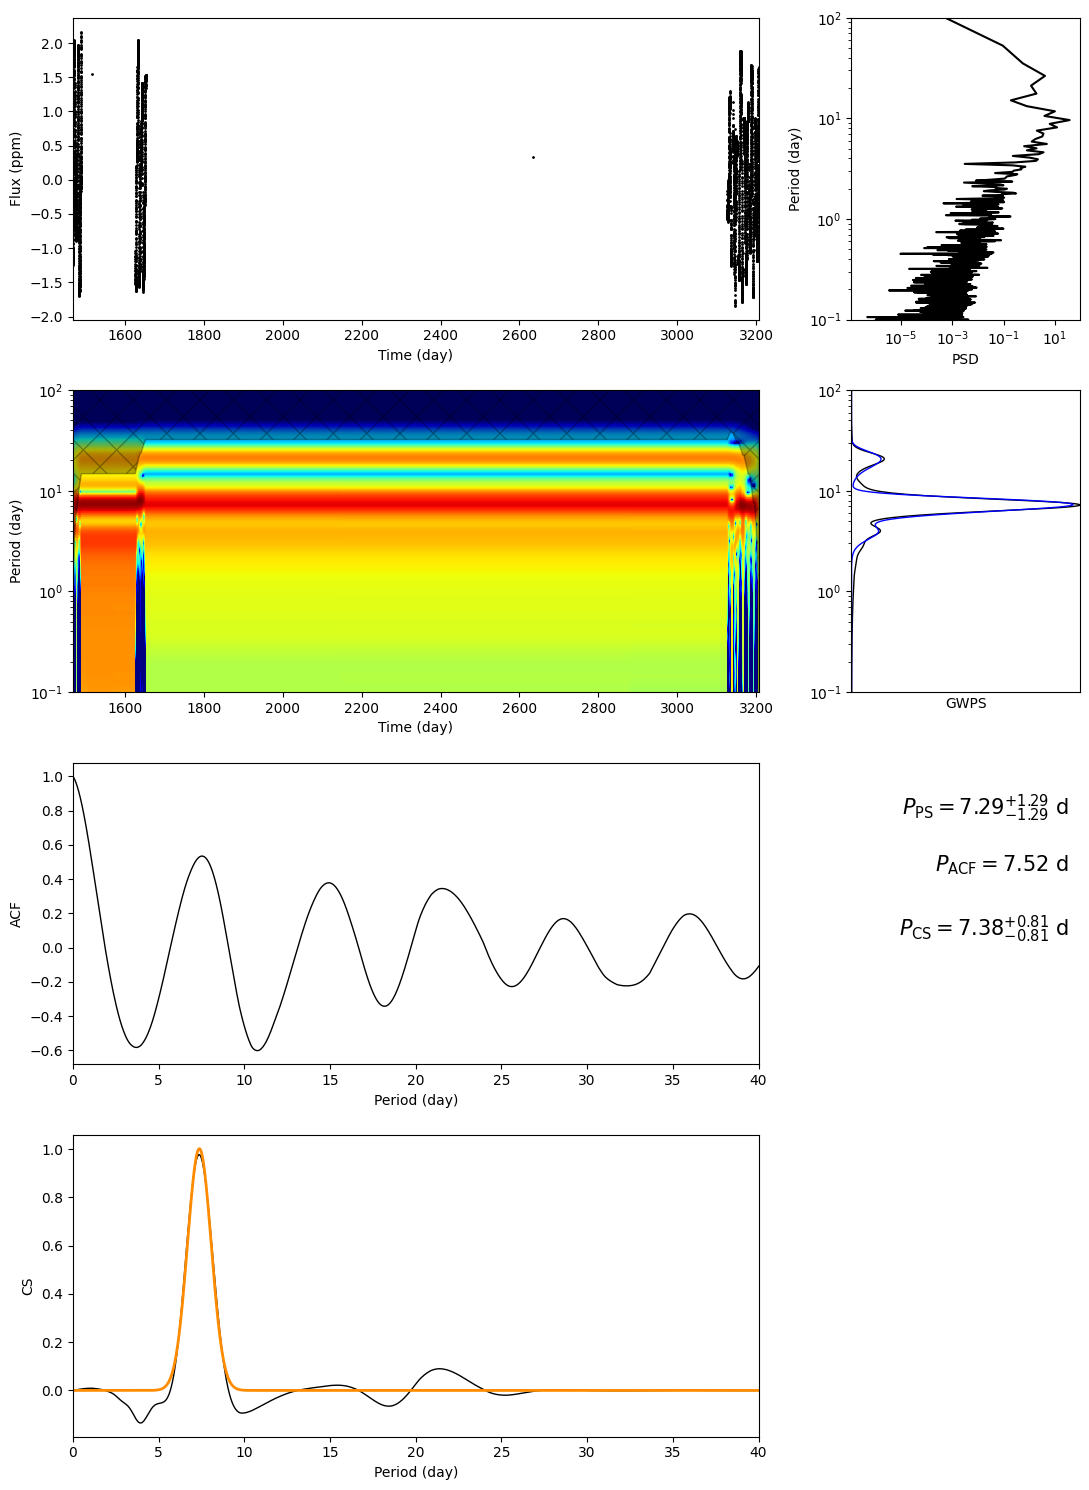

In [ ]:

flare_amplitude = np.percentile(f_clean, 99.5) - np.median(f_clean)

if flare_amplitude > 0.05:   # >5% flares → dangerous for heavy rebinning
    bin_h = 0.5              # reduce to 30 minutes max
    print(f"Extreme flaring detected ({flare_amplitude:.1%} excess) → reducing rebinning to {bin_h}h")
elif flare_amplitude > 0.02:
    bin_h = 2.0
else:
    bin_h = 4.0



if bin_h is not None and bin_h > 0:

    median_cadence_days = np.median(np.diff(t))
    median_cadence_hours = median_cadence_days * 24
    nrebin_points = max(1, int(bin_h / median_cadence_hours)) # Number of original points to group

    t_bin, f_bin = sp.rebin(t, nrebin_points), sp.rebin(f_clean, nrebin_points)
    dt = bin_h * 3600
    print(f"Rebinned to {bin_h}h → {len(t_bin)} points")
else:
    t_bin, f_bin = t, f_clean
    dt = np.median(np.diff(t)) * 24 * 3600
    print("Rebinning skipped → using full 2-minute cadence")
    os.makedirs("HIP33690_results", exist_ok=True)

(p_wps, p_acf, gwps, wps, acf, cs, coi, features, feature_names, fig) = sp.analysis_pipeline(
    t_bin, f_bin,
    figsize=(11,15), plot=True, xlim=(0,40),
    normscale='log', ylogscale=True,
    add_periodogram=True, wavelet_analysis=True
)

plt.savefig("HIP33690_results/ROOSTER_full.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
periods, _, gwps_full, _, _ = sp.compute_wps(f_bin, dt, normalise=True)
prot_gauss, err_gauss, _ = sp.compute_prot_err_gaussian_fit(periods, gwps_full, n_profile=5)

print(f"Rotation period from Gaussian fit: {prot_gauss:.3f} +/- {err_gauss:.3f} days")

Rotation period from Gaussian fit: 7.291 +/- 1.289 days


In [ ]:
import lightkurve as lk
lk.search_lightcurve("TIC 167814656", sector=[6,12,67,68,69]).table['mission']


<Column name='mission' dtype='object' length=23>
TESS Sector 06
TESS Sector 12
TESS Sector 68
TESS Sector 67
TESS Sector 69
TESS Sector 69
TESS Sector 68
TESS Sector 67
TESS Sector 06
TESS Sector 12
TESS Sector 69
TESS Sector 68
TESS Sector 67
TESS Sector 06
TESS Sector 12
TESS Sector 69
TESS Sector 68
TESS Sector 67
TESS Sector 06
TESS Sector 06
TESS Sector 06
TESS Sector 06
TESS Sector 12

In [ ]:
# 8. FINAL TABLE
p_wps_scalar = features[feature_names.index('prot_ps')]
p_acf_scalar = features[feature_names.index('prot_acf')]
e_wps_scalar = features[feature_names.index('e_prot_ps')]
e_acf_scalar = features[feature_names.index('e_prot_acf')]

results = pd.DataFrame({
    "Method": ["Lightkurve LS", "ROOSTER Wavelet", "ROOSTER ACF", "ROOSTER Gaussian", "Literature"],
    "Period (days)": [ls_period, p_wps_scalar, p_acf_scalar, prot_gauss, 9.60],
    "Error (days)": ["—", f"±{e_wps_scalar:.3f}", f"±{e_acf_scalar:.3f}", f"±{err_gauss:.3f}", "±0.10"]
})

results.to_csv("HIP33690_results/table.csv", index=False)
results.to_latex("HIP33690_results/table.tex", index=False, escape=False)
print("\nFINAL RESULTS FOR YOUR THESIS:")
display(results)


FINAL RESULTS FOR YOUR THESIS:


,Method,Period (days),Error (days)
0,Lightkurve LS,9.489470,—
1,ROOSTER Wavelet,7.291077,±1.289
2,ROOSTER ACF,7.520820,±-1.000
3,ROOSTER Gaussian,7.291090,±1.289
4,Literature,9.600000,±0.10
